<a href="https://colab.research.google.com/github/AfifaMasood/AfifaMasood/blob/main/AllahBad_transfer_learning_with_movinet_shoplifting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Transfer learning for video classification with MoViNet

MoViNets (Mobile Video Networks) provide a family of efficient video classification models, supporting inference on streaming video. In this tutorial, you will use a pre-trained MoViNet model to classify videos, specifically for an action recognition task, from the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). A pre-trained model is a saved network that was previously trained on a larger dataset. You can find more details about MoViNets in the [MoViNets: Mobile Video Networks for Efficient Video Recognition](https://arxiv.org/abs/2103.11511) paper by Kondratyuk, D. et al. (2021). In this tutorial, you will:

* Learn how to download a pre-trained MoViNet model
* Create a new model using a pre-trained model with a new classifier by freezing the convolutional base of the MoViNet model
* Replace the classifier head with the number of labels of a new dataset
* Perform transfer learning on the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)

The model downloaded in this tutorial is from [official/projects/movinet](https://github.com/tensorflow/models/tree/master/official/projects/movinet). This repository contains a collection of MoViNet models that TF Hub uses in the TensorFlow 2 SavedModel format.

This transfer learning tutorial is the third part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document; in particular, how to preprocess and load data through the `FrameGenerator` class is explained in more detail.
- [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification). Note that this tutorial uses a (2+1)D CNN that decomposes the spatial and temporal aspects of 3D data; if you are using volumetric data such as an MRI scan, consider using a 3D CNN instead of a (2+1)D CNN.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files (ensure that `opencv-python` and `opencv-python-headless` are the same version), and TensorFlow models ([`tf-models-official`](https://github.com/tensorflow/models/tree/master/official)) to download the pre-trained MoViNet model. The TensorFlow models package are a collection of models that use TensorFlow’s high-level APIs.

In [ ]:
!pip install opencv-python # Install the latest version of opencv-python
!pip install opencv-python-headless # Install the latest version of opencv-python-headless
!pip install  tqdm tf-models-official
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade --force-reinstall numpy matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

## Load data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. The [Loading video data tutorial](https://www.tensorflow.org/tutorials/load_data/video) provides a detailed walkthrough of this code.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.



In [ ]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """Initializes FrameGenerator with path, number of frames, and training mode."""
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = ['Shoplifting', 'Normal']
        self.class_ids_for_name = {'Normal': 0, 'Shoplifting': 1}

    def get_files_and_class_names(self):
        # Collect both .mp4 and .avi files
        video_paths = list(self.path.glob('*/*.mp4')) + list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

def frames_from_video_file(video_path, n_frames, output_size=(256, 256), frame_step=15):
    """
    Extracts frames from a video file.

    Args:
        video_path: Path to the video file.
        n_frames: Number of frames to extract.
        output_size: The size to which each frame should be resized.
        frame_step: Number of frames to skip between each extracted frame.

    Returns:
        A NumPy array of frames with shape (n_frames, height, width, channels).
    """
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step

    # Determine the start point for frame extraction
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    # Extract frames by stepping through the video
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))  # Fill with empty frames if video ends

    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB

    return result

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame


Create the training and test datasets:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

# Update to your Google Drive dataset paths
train_path = pathlib.Path('/content/drive/MyDrive/FYP-Dataset-Allahbad-split/train')
val_path = pathlib.Path('/content/drive/MyDrive/FYP-Dataset-Allahbad-split/val')
test_path = pathlib.Path('/content/drive/MyDrive/FYP-Dataset-Allahbad-split/test')

# Create train, validation, and test datasets
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(train_path, num_frames, training=True),
    output_signature=output_signature
).batch(batch_size)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(val_path, num_frames),
    output_signature=output_signature
).batch(batch_size)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(test_path, num_frames),
    output_signature=output_signature
).batch(batch_size)


Mounted at /content/drive


The labels generated here represent the encoding of the classes. For instance, 'ApplyEyeMakeup' is mapped to the integer Take a look at the labels of the training data to ensure that the dataset has been sufficiently shuffled.

In [ ]:
print(f"Train Dataset: {train_ds}")


Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>


In [ ]:
for frames, labels in train_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")
  print(labels)

Shape: (8, 8, 256, 256, 3)
Label: (8,)
tf.Tensor([0 1 1 1 1 1 0 0], shape=(8,), dtype=int16)


In [ ]:
frame_count = 0
for frames, labels in train_ds:
    frame_count += frames.shape[1]  # frames.shape[1] gives number of frames per video
print(f"Total frames processed: {frame_count}")


Total frames processed: 280


Take a look at the shape of the data.

## What are MoViNets?

As mentioned previously, [MoViNets](https://arxiv.org/abs/2103.11511) are video classification models used for streaming video or online inference in tasks, such as action recognition. Consider using MoViNets to classify your video data for action recognition.

A 2D frame based classifier is efficient and simple to run over whole videos, or streaming one frame at a time. Because they can't take temporal context into account they have limited accuracy and may give inconsistent outputs from frame to frame.

A simple 3D CNN uses bidirectional temporal context which can increase accuracy and temporal consistency. These networks may require more resources and because they look into the future they can't be used for streaming data.

![Standard convolution](https://www.tensorflow.org/images/tutorials/video/standard_convolution.png)

The MoViNet architecture uses 3D convolutions that are "causal" along the time axis (like `layers.Conv1D` with `padding="causal"`). This gives some of the advantages of both approaches, mainly it allow for efficient streaming.

![Causal convolution](https://www.tensorflow.org/images/tutorials/video/causal_convolution.png)

Causal convolution ensures that the output at time *t* is computed using only inputs up to time *t*. To demonstrate how this can make streaming more efficient, start with a simpler example you may be familiar with: an RNN. The RNN passes state forward through time:

![RNN model](https://www.tensorflow.org/images/tutorials/video/rnn_comparison.png)

In [ ]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1, 10, 8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once
print("Shape of inputs:", inputs.shape)
print("Shape of result:", result.shape)
print("Shape of state:", state.shape)

Shape of inputs: (1, 10, 8)
Shape of result: (1, 10, 4)
Shape of state: (1, 4)


By setting the RNN's `return_sequences=True` argument you ask it to return the state at the end of the computation. This allows you to pause and then continue where you left off, to get exactly the same result:

![States passing in RNNs](https://www.tensorflow.org/images/tutorials/video/rnn_state_passing.png)

In [ ]:
first_half, state = gru(inputs[:, :5, :])   # run the first half, and capture the state # Now `state` shape is (1, 4)
second_half, _ = gru(inputs[:,5:, :], initial_state=state)  # Use the state to continue where you left off.

print(np.allclose(result[:, :5,:], first_half))
print(np.allclose(result[:, 5:,:], second_half))

True
True


Causal convolutions can be used the same way, if handled with care. This technique was used in the [Fast Wavenet Generation Algorithm](https://arxiv.org/abs/1611.09482) by Le Paine et al. In the [MoVinet paper](https://arxiv.org/abs/2103.11511), the `state` is referred to as the "Stream Buffer".

![States passed in causal convolution](https://www.tensorflow.org/images/tutorials/video/causal_conv_states.png)

By passing this little bit of state forward, you can avoid recalculating the whole receptive field that shown above.

## Download a pre-trained MoViNet model

In this section, you will:

1. You can create a MoViNet model using the open source code provided in [`official/projects/movinet`](https://github.com/tensorflow/models/tree/master/official/projects/movinet) from TensorFlow models.
2. Load the pretrained weights.
3. Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

To build the model, you can start with the `a0` configuration because it is the fastest to train when benchmarked against other models. Check out the [available MoViNet models on TensorFlow Model Garden](https://github.com/tensorflow/models/blob/master/official/projects/movinet/configs/movinet.py) to find what might work for your use case.

In [ ]:
model_id = 'a0'
resolution = 224

# Clear any previous session
tf.keras.backend.clear_session()

# Load the backbone with pre-trained weights
backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 initially to match pre-trained weights, and then redefine for fine-tuning
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Download and extract pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

# Load the weights from the checkpoint
checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

# Redefine the model for binary classification (shoplifting vs. Normal) after loading weights
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=2)
model.build([None, None, None, resolution, 3])  # Now with your target resolution


movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 2)

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

# Clear the session to avoid any conflicts
K.clear_session()

num_epochs = 5
loss_obj = SparseCategoricalCrossentropy(from_logits=True)
# Instead of directly creating an optimizer object, pass the optimizer as a string
optimizer = 'adam' # 'Adam'  # Use string identifier for Adam optimizer

# Compile the model
model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

Train the model. After two epochs, observe a low loss with high accuracy for both the training and test sets.

In [ ]:
# If dataset is finite, you can count the steps per epoch
steps_per_epoch = sum(1 for _ in train_ds)
print("Steps per epoch:", steps_per_epoch)


Steps per epoch: 35


In [ ]:
# If dataset is finite, you can count the steps per epoch
steps_per_epoch_val_ds = sum(1 for _ in val_ds)
print("Steps per epoch:", steps_per_epoch)


Steps per epoch: 35


In [ ]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/5
35/35 [==============================] - 3288s 93s/step - loss: 0.1948 - accuracy: 0.9321 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 2/5
35/35 [==============================] - 3177s 91s/step - loss: 0.0318 - accuracy: 0.9929 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 3/5
35/35 [==============================] - 3171s 91s/step - loss: 0.0081 - accuracy: 0.9964 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 4/5
35/35 [==============================] - 3185s 91s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/5
35/35 [==============================] - 3198s 91s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000


## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [ ]:
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 612s 71s/step - loss: 0.1213 - accuracy: 0.9833


{'loss': 0.12125138193368912, 'accuracy': 0.9833333492279053}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. To build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted



In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    # 🟢 Force data types to match
    actual = tf.cast(actual, tf.int32)
    predicted = tf.cast(predicted, tf.int32)

    # Generate confusion matrix
    cm = tf.math.confusion_matrix(actual, predicted).numpy()

    # Plot
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                     xticklabels=labels, yticklabels=labels)

    ax.set_title('Confusion Matrix for ' + ds_type)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
print("Actual dtype:", actual.dtype)
print("Predicted dtype:", predicted.dtype)
print("Actual shape:", actual.shape)
print("Predicted shape:", predicted.shape)


Actual dtype: <dtype: 'int16'>
Predicted dtype: <dtype: 'int64'>
Actual shape: (60,)
Predicted shape: (60,)


In [ ]:
fg = FrameGenerator(train_path, num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

8/8 [==============================] - 583s 70s/step


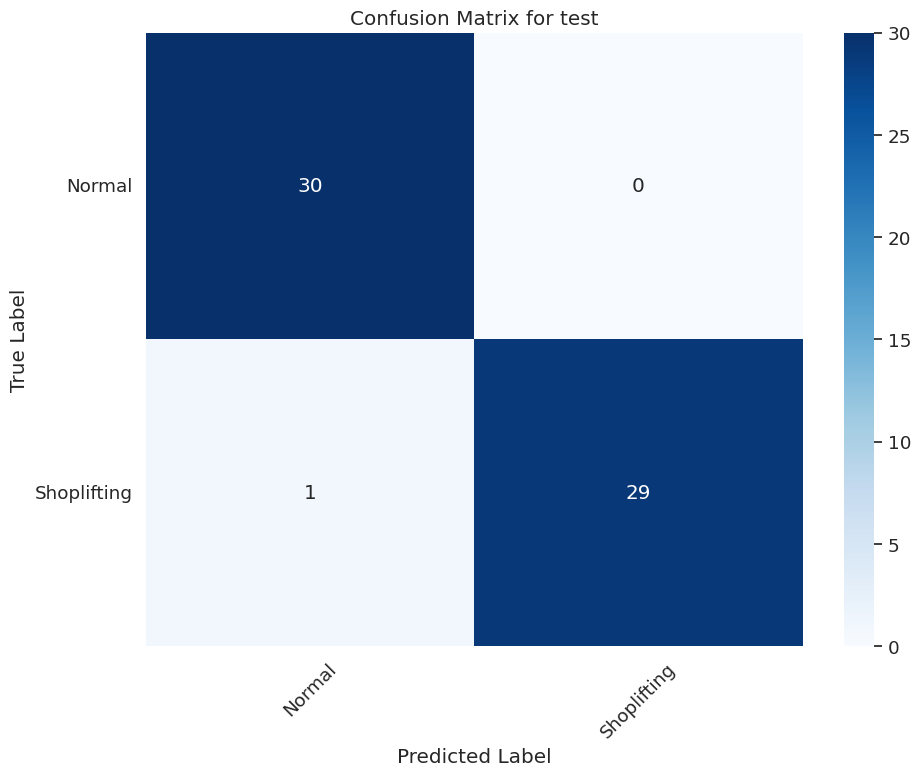

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)

# Force same dtype before plotting
actual = tf.cast(actual, tf.int32)
predicted = tf.cast(predicted, tf.int32)

plot_confusion_matrix(actual, predicted, label_names, 'test')


In [ ]:
%matplotlib inline


In [ ]:
from sklearn.metrics import f1_score

# Get actual and predicted labels
actual, predicted = get_actual_predicted_labels(test_ds)

# Ensure both are numpy arrays and same dtype
actual = actual.numpy()
predicted = predicted.numpy()

# Compute F1 score
f1 = f1_score(actual, predicted, average='binary')  # or 'macro' for multi-class
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9831


In [ ]:
def plot_curve(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric1 = model_training_history.history[metric_name_1]
    metric2 = model_training_history.history[metric_name_2]

    epochs = range(1, len(metric1) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, metric1, color='blue', label=metric_name_1)
    plt.plot(epochs, metric2, color='red', label=metric_name_2)
    plt.title(plot_name)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
%matplotlib inline


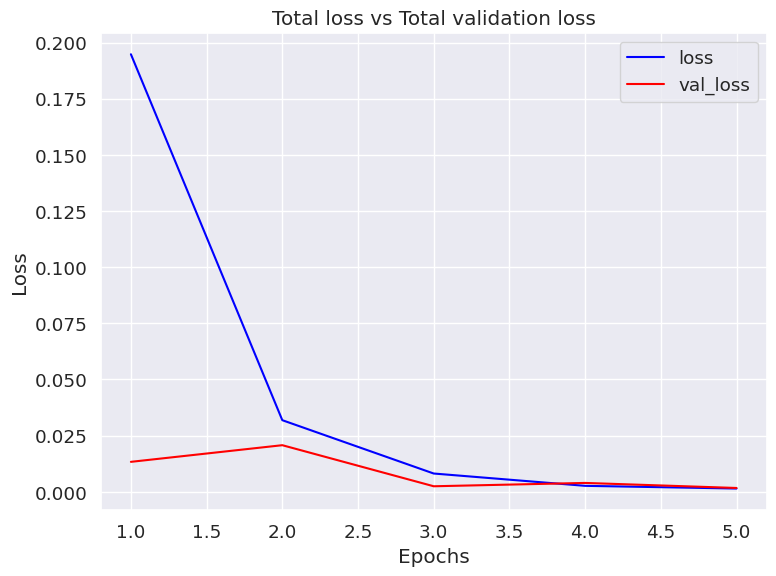

In [ ]:
plot_curve(results, 'loss', 'val_loss', "Total loss vs Total validation loss")

In [ ]:

save_path = "/content/drive/MyDrive/MOVINET_SHOPLIFTING_AllahBad"
model.save(save_path)

## Next steps

Now that you have some familiarity with the MoViNet model and how to leverage various TensorFlow APIs (for example, for transfer learning), try using the code in this tutorial with your own dataset. The data does not have to be limited to video data. Volumetric data, such as MRI scans, can also be used with 3D CNNs. The NUSDAT and IMH datasets mentioned in [Brain MRI-based 3D Convolutional Neural Networks for Classification of Schizophrenia and Controls](https://arxiv.org/pdf/2003.08818.pdf) could be two such sources for MRI data.

In particular, using the `FrameGenerator` class used in this tutorial and the other video data and classification tutorials will help you load data into your models.

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)